# COMP30760 ASSIGNMENT 1 - TASK 2 - 18439746 - Matthew O'Donnell
In this assignment we will collect detailed channel, video and playlist data from the Youtube Data API v3 for five different youtube channels (BT Sport, Fox Sports, Google Analytics, Marvel HQ, Netflix Futures).

This notebook covers Task 2 - Data Preparation and Analysis. We will use all of the JSON data collected during Task 1 to perform the analysis process.

In [2]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline
from IPython.display import display_html
from itertools import chain,cycle
import numpy as np
import math

Some of the key settings, including our channel titles/IDs, category names, base url and some other appearance settings which we will use for plotting

In [3]:
# The names of the Youtube channels we would like to analyse
channel_names = ["BT Sport", "Fox Sports", "Google Analytics", "Marvel HQ", "Netflix Futures"]
# The channel ID's for each of these Youtube channels
channel_ids = {"BT Sport":"UC4i_9WvfPRTuRWEaWyfKuFw", "Fox Sports":"UCwNqHDsnBCKT-olwJwIFyfg",
                    "Google Analytics":"UCJ5UyIAa5nEGksjcdp43Ixw", "Marvel HQ":"UCxwitsUVNzwS5XBSC5UQV8Q",
                    "Netflix Futures":"UCpInjhuJ1WUekcFeXPPyGGg"}
category_names= {"channels", "videos", "playlists"}

# Precision that we'll use for Pandas display
pd.set_option('precision', 2)
# Colors that we will use in various plots
channel_colours = {"BT Sport":"black", "Fox Sports":"orange", "Google Analytics":"green", "Marvel HQ":"navy", "Netflix Futures":"darkred"}
# Default font size
fontsize = 13
url = "/Users/matthew/raw/"

Directories for data storage

In [4]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

# Data Preprocessing 
Before we can analyse the data, we need to transform it into a usable format.
Firstly find all of the raw Json files and seperate them by channel

In [5]:
channel_files = {}
for channel_name in channel_names:
    channel_files[channel_name] = []
for fpath in dir_raw.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("*")
        if parts[0] in channel_names:
            channel_files[parts[0]].append(fpath)
for channel_name in channel_names:
    print("%s: Found %d raw data files" % (channel_name, len(channel_files[channel_name])))

BT Sport: Found 4 raw data files
Fox Sports: Found 4 raw data files
Google Analytics: Found 4 raw data files
Marvel HQ: Found 4 raw data files
Netflix Futures: Found 4 raw data files


# Data Parsing and Merging
We will define several functions that will parse videos, channels and playlists from their seperate JSON files

Firstly we parse the channel data

In [6]:
def parse_channel_data(df, channel_name, fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    for channel in data['items']:
            channel_id = channel["id"]
            channel_title = channel['snippet']['title']
            channel_views = channel['statistics']['viewCount']
            videoCount = channel['statistics']['videoCount']
            subscriberCount = channel['statistics']['subscriberCount']
            hidden_sub_count = channel['statistics']['hiddenSubscriberCount']
            channel_title = channel['snippet']['title']
            channel_launch_date = channel['snippet']['publishedAt']
            channel_launch_date = str(channel_launch_date).split("T")[0]
            
            df = df.append ({'channel_id': channel_id, 'channel_title': channel_title, 'channel_launch': channel_launch_date,'channel_views' : channel_views,'subscriber_count' : subscriberCount, 'hidden_sub_count' : hidden_sub_count, 'videoCount' : videoCount}, ignore_index=True)
        
    fin.close()
    return df 

Then we merge the data we obtained for each of our channels to get a dataframe containing all of our channels' stats 

In [7]:
def merge_channels(df):
    for channel_name in channel_names:
        df = parse_channel_data(df, channel_name, url + channel_name + "-channels.json")
    return df

In [8]:
dFChannels = pd.DataFrame(columns=["channel_id", "channel_title", "channel_launch", "channel_views", "subscriber_count", "hidden_sub_count", "videoCount"])
dFChannels = merge_channels(dFChannels)
dFChannels

,channel_id,channel_title,channel_launch,channel_views,subscriber_count,hidden_sub_count,videoCount
0,UC4i_9WvfPRTuRWEaWyfKuFw,BT Sport,2013-01-02,2309919513,4010000,False,8599
1,UCwNqHDsnBCKT-olwJwIFyfg,FOX Sports,2006-06-05,538997432,955000,False,4436
2,UCJ5UyIAa5nEGksjcdp43Ixw,Google Analytics,2008-02-25,50421335,375000,False,461
3,UCxwitsUVNzwS5XBSC5UQV8Q,Marvel HQ,2017-09-12,780457702,1720000,False,640
4,UCpInjhuJ1WUekcFeXPPyGGg,Netflix Futures,2017-10-16,1213416024,3070000,False,1367


Next we define a function to get the additional video statistics which are stored in our video details file

In [9]:
def video_stats(video_id, fpath):

    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)

    view_count = data[video_id]['items'][0]['statistics']['viewCount']
    like_count = data[video_id]['items'][0]['statistics']['likeCount']
    dislike_count = data[video_id]['items'][0]['statistics']['dislikeCount']
    comment_count = data[video_id]['items'][0]['statistics']['commentCount']

    return view_count, like_count, dislike_count, comment_count

We parse the video data and use our video_stats function to help us obtain **all** video data 

In [10]:
def parse_video_data(df, channel_name, fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    for video in data['items']:
        if video['id']['kind'] == "youtube#video":
            channel_id = video["snippet"]["channelId"]
            video_id = video['id']['videoId']
            video_title = video['snippet']['title']
            video_title = str(video_title).replace("&amp;","")
            upload_date = video['snippet']['publishedAt']
            upload_date = str(upload_date).split("T")[0]
            view_count, like_count, dislike_count, comment_count = video_stats(video_id, url + channel_name + "---videoDetails.json")
            
            df = df.append ({'video_id': video_id, 'video_title': video_title, 'upload_date': upload_date,'view_count' : view_count, 'like_count' : like_count, 'dislike_count' : dislike_count, 'comment_count' : comment_count, 'channel_id': channel_id}, ignore_index=True)
    
        
    fin.close()
    return df 

We merge our video data to get a dataframe containing multiple videos from each channel

In [11]:
def merge_videos(df):
    for channel_name in channel_names:
        df = parse_video_data(df, channel_name, url + channel_name + "---videos.json")
    return df

In [12]:
dFVideos = pd.DataFrame(columns=["video_id","video_title","upload_date","view_count","like_count", "dislike_count","comment_count", "channel_id"])
dFVideos = merge_videos(dFVideos)
dFVideos.head(5)

,video_id,video_title,upload_date,view_count,like_count,dislike_count,comment_count,channel_id
0,gygi4biFcXk,&quot;You have to give credit...&quot; Maurici...,2021-11-24,22800,474,19,190,UC4i_9WvfPRTuRWEaWyfKuFw
1,SER8xp5jEGE,Jurgen Klopp delighted with Tyler Morton&#39;s...,2021-11-24,17420,611,11,50,UC4i_9WvfPRTuRWEaWyfKuFw
2,d3P0FhE7o5Y,&quot;I&#39;ve scored prettier!&quot; Oxlade-C...,2021-11-24,57665,2052,22,158,UC4i_9WvfPRTuRWEaWyfKuFw
3,kj5NHfUnUVI,Who Should Be The Next Manchester United Manag...,2021-11-24,248728,3157,71,907,UC4i_9WvfPRTuRWEaWyfKuFw
4,fofkRfrrKD0,Thomas Tuchel hails &#39;&quot;amazing perfoma...,2021-11-23,133042,3871,28,311,UC4i_9WvfPRTuRWEaWyfKuFw


We then parse the playlist data to obtain a number of playlists from each of our five channels

In [13]:
def parse_playlist_data(df, channel_name, fpath):
    fin = open(fpath, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    for playlist in data['items']:
        channel_id = playlist["snippet"]["channelId"]
        playlist_id = playlist['id']
        playlist_title = playlist['snippet']['title']
        playlist_title = str(playlist_title).replace("&amp;","")
        upload_date = playlist['snippet']['publishedAt']
        upload_date = str(upload_date).split("T")[0]
        number_videos = playlist['contentDetails']['itemCount']
        privacy_status = playlist['status']['privacyStatus']
            
        df = df.append ({'playlist_id': playlist_id, 'playlist_title': playlist_title, 'upload_date': upload_date,'number_videos' : number_videos, 'privacy_status' : privacy_status, 'channel_id' : channel_id}, ignore_index=True)
    
    fin.close()
    return df

We merge our playlist data to get a data frame containing playlists from each of our five channels

In [14]:
def merge_playlists(df):
    for channel_name in channel_names:
        df = parse_playlist_data(df, channel_name, url + channel_name + "---playlists.json")
    return df

In [15]:
dFPlaylists = pd.DataFrame(columns=["playlist_id", "playlist_title", "upload_date" ,"number_videos" , "privacy_status", "channel_id"])
dFPlaylists = merge_playlists(dFPlaylists)
dFPlaylists.head(5)

,playlist_id,playlist_title,upload_date,number_videos,privacy_status,channel_id
0,PLubVgegS36EOtpkDuX998WLzAjPrnsLtK,WWE Survivor Series 2021: Brooklyn,2021-11-16,17,public,UC4i_9WvfPRTuRWEaWyfKuFw
1,PLubVgegS36EMGc7501nXKoFYkeQdW62ht,"UFC 268 | Usman, Rose and Gaethje win gold in ...",2021-11-01,49,public,UC4i_9WvfPRTuRWEaWyfKuFw
2,PLubVgegS36EOjscQ0QwiqBMFPp8_kE6ov,"UFC 267: Yan, Makhachev, Chimaev and Texeira w...",2021-10-22,25,public,UC4i_9WvfPRTuRWEaWyfKuFw
3,PLubVgegS36EMEw-lqVkoMcdkCByYjVEUX,"#UCLTONIGHT Show: Debate, Analysis & Insight O...",2021-09-30,23,public,UC4i_9WvfPRTuRWEaWyfKuFw
4,PLubVgegS36EPdX69I91S7ubUkQ9ESoDlr,UEFA Europa League Interviews & Analysis 2021/22,2021-09-16,22,public,UC4i_9WvfPRTuRWEaWyfKuFw



We then create a nested dictionary called catgeories which will store each of our categories data frames

In [16]:
df_categories = {"channels":dFChannels, "videos":dFVideos, "playlists":dFPlaylists}


## Data Verification
First we check the format of one of our newly created Data Frames

In [17]:
df_categories["videos"].head(5)

,video_id,video_title,upload_date,view_count,like_count,dislike_count,comment_count,channel_id
0,gygi4biFcXk,&quot;You have to give credit...&quot; Maurici...,2021-11-24,22800,474,19,190,UC4i_9WvfPRTuRWEaWyfKuFw
1,SER8xp5jEGE,Jurgen Klopp delighted with Tyler Morton&#39;s...,2021-11-24,17420,611,11,50,UC4i_9WvfPRTuRWEaWyfKuFw
2,d3P0FhE7o5Y,&quot;I&#39;ve scored prettier!&quot; Oxlade-C...,2021-11-24,57665,2052,22,158,UC4i_9WvfPRTuRWEaWyfKuFw
3,kj5NHfUnUVI,Who Should Be The Next Manchester United Manag...,2021-11-24,248728,3157,71,907,UC4i_9WvfPRTuRWEaWyfKuFw
4,fofkRfrrKD0,Thomas Tuchel hails &#39;&quot;amazing perfoma...,2021-11-23,133042,3871,28,311,UC4i_9WvfPRTuRWEaWyfKuFw


Next we count the rows in each of our data frames and we also get a range of the dates

In [18]:
def row_summary():
    rows = []
    word = "date"
    word2 = "launch"
    for category_name in category_names:
        for col_name in df_categories[category_name].columns:
            row = {"Category": category_name}
            row["Rows"] = len(df_categories[category_name])
            if word in col_name or word2 in col_name:
                row["DateStart"] = df_categories[category_name][col_name].min()
                row["DateEnd"] = df_categories[category_name][col_name].max()
                rows.append(row)
    return pd.DataFrame(rows).set_index("Category")

# display the number of rows
df_row_summary1 = row_summary()
df_row_summary1

,Rows,DateStart,DateEnd
Category,,,
videos,248,2019-08-12,2021-11-25
playlists,100,2014-11-06,2021-11-20
channels,5,2006-06-05,2017-10-16


Next we make sure that we don't have any missing values (i.e. Nulls) in any of our Data Frames 

In [19]:
for category_name in category_names:
    print("-- %s" % category_name)
    missing_counts = df_categories[category_name].isnull().sum()
    # which columns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- videos
No missing values found
-- playlists
No missing values found
-- channels
No missing values found


### Data Saving 
Next, we write all of the merged category data frames in JSON format, one file per category. These will represent the 'clean' data that we will use for our actual **Data Analysis**

In [20]:
for category_name in category_names:
    fname = "%s.json" % category_name
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    df_categories[category_name].to_json(out_path, orient="index", indent=4)

Writing data/videos.json
Writing data/playlists.json
Writing data/channels.json


## Data Analysis 
### Data Loading
We will then reload the category data frames which we had previously stored

In [21]:
df_categories = {}
for category_name in category_names:
    fname = "%s.json" % category_name
    in_path = dir_data / fname
    df_categories[category_name] = pd.read_json(in_path, orient="index")
    print("%s: %d rows of data" % 
          (category_name, len(df_categories[category_name])))

videos: 248 rows of data
playlists: 100 rows of data
channels: 5 rows of data


Check the format of one of our newly read Category data frames

In [22]:
df_categories["videos"].head(5)

,video_id,video_title,upload_date,view_count,like_count,dislike_count,comment_count,channel_id
0,gygi4biFcXk,&quot;You have to give credit...&quot; Maurici...,2021-11-24,22800,474,19,190,UC4i_9WvfPRTuRWEaWyfKuFw
1,SER8xp5jEGE,Jurgen Klopp delighted with Tyler Morton&#39;s...,2021-11-24,17420,611,11,50,UC4i_9WvfPRTuRWEaWyfKuFw
2,d3P0FhE7o5Y,&quot;I&#39;ve scored prettier!&quot; Oxlade-C...,2021-11-24,57665,2052,22,158,UC4i_9WvfPRTuRWEaWyfKuFw
3,kj5NHfUnUVI,Who Should Be The Next Manchester United Manag...,2021-11-24,248728,3157,71,907,UC4i_9WvfPRTuRWEaWyfKuFw
4,fofkRfrrKD0,Thomas Tuchel hails &#39;&quot;amazing perfoma...,2021-11-23,133042,3871,28,311,UC4i_9WvfPRTuRWEaWyfKuFw


### Video View Count Analysis 
First we will look at video view count data. We can just look at the raw statistics for each of our videos across each of our channels. We'll create a function to do this, which we will reuse later

In [54]:
def compute_category_stats(cname, col_name):
    rows = []
    #count = 0;
    #total = len(df_categories[category_name])
    #while (count<total):
    for channel_name in channel_names:
        row = {cname : channel_name}
        row["Min"] = df_categories[cname][df_categories[cname].channel_id == channel_ids[channel_name]][col_name].min()
        row["Max"] = df_categories[cname][df_categories[cname].channel_id == channel_ids[channel_name]][col_name].max()
        row["Mean"] = df_categories[cname][df_categories[cname].channel_id == channel_ids[channel_name]][col_name].mean()
        row["Median"] = df_categories[cname][df_categories[cname].channel_id == channel_ids[channel_name]][col_name].median()
        rows.append(row)
    return pd.DataFrame(rows)#.set_index("Channels")

In [24]:
df_view_stats1 = compute_category_stats("videos","view_count")
df_view_stats1

,Channels,Min,Max,Mean,Median
0,BT Sport,6539,1413556,191743.66,109043.0
1,Fox Sports,75,1499460,180790.54,104993.5
2,Google Analytics,1606,131139,16712.52,7319.5
3,Marvel HQ,4864,22351852,914557.88,48750.5
4,Netflix Futures,2919,6952721,523711.82,111251.5


## General Video Statistics
Get the general statistics of our videos including things like the most liked/disliked videos

In [25]:
result_df = df_categories["videos"].sort_values(by = 'view_count', ascending = False)
top10 = result_df.head(10)

## Most Viewed Videos - All channels

Text(0.5, 1.0, 'Top ten most viewed videos')

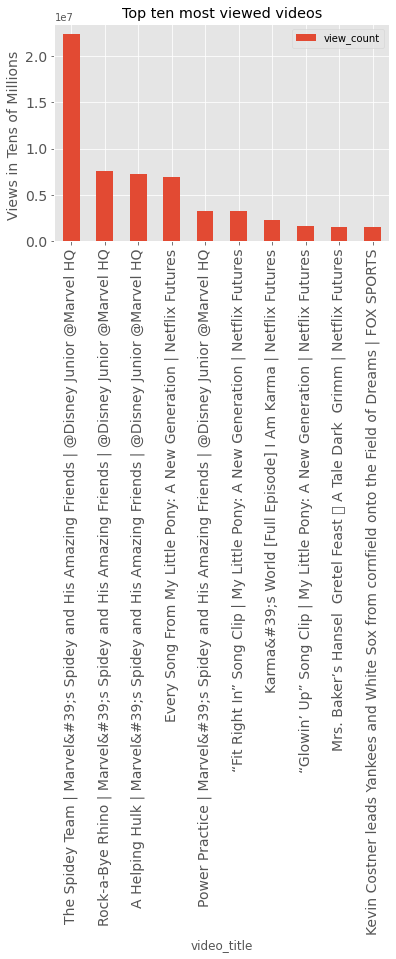

In [107]:
ax = top10.plot.bar(x='video_title', y='view_count', fontsize=14)
ax.set_ylabel("Views in Tens of Millions ", fontsize=14)
plt.title('Top ten most viewed videos')

From the plots above, we can see our top ten most viewed videos across all of our channels. We can see that three channels appear here (Marvel HQ, Netflix Futures and Fox Sports). 
From the plots we can also see that only one video (in all of the 248 videos selected from our five youtube channels) exceeds ten million views. 'The Spidey Team' video from the Marvel HQ channel is our most viewed video with over 22 million views.  

### Likes, Dislikes and Comments for our Most Viewed Videos

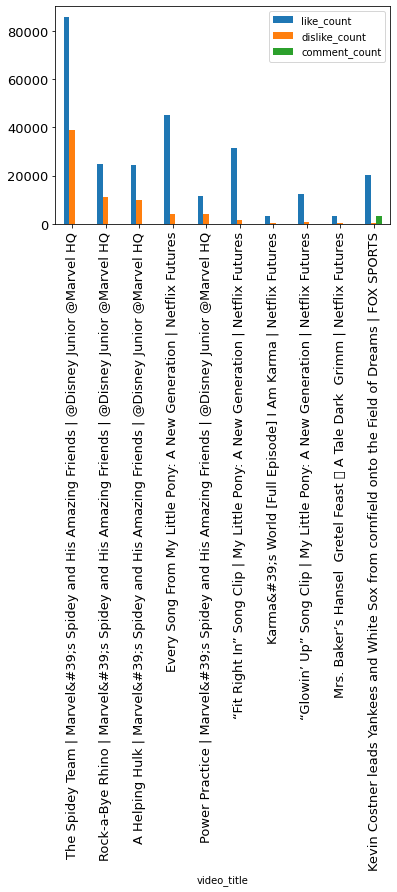

In [28]:
likes_avg = top10['like_count']
axis = top10.plot.bar(x='video_title', y=['like_count', 'dislike_count', 'comment_count'], fontsize=fontsize)

We can see from our graph above that most of our top viewed videos have no comments at all. This is probably due to the fact that Marvel HQ and Netflix Futures disable comments on a lot of their videos as they are often for kids. We also see that like count for our videos is always at least double dislike count. Our most liked video is also our most viewed video ('The Spidey Team'). However some of the other videos in our top ten have less views than other video but more likes than them. 

## Least Viewed Videos (All Channels)

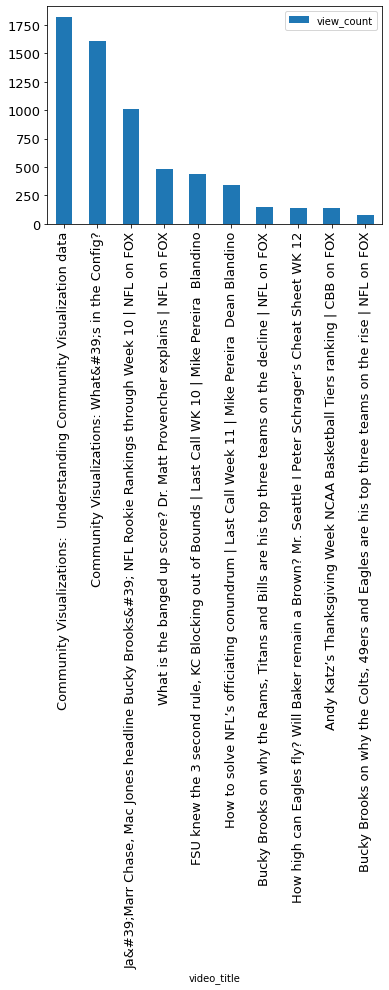

In [29]:
bottom10 = result_df.tail(10)
axis = bottom10.plot.bar(x='video_title', y='view_count', fontsize = fontsize)

From the plots above, we can see our top ten least viewed videos across all of our channels. From the plots we can see that all of our bottom 10 videos have less than two thousand views with the least viewed video having as little as 75 views. If we were to check these videos, we would asssume that their publish date would be more recent than most

### Likes, Dislikes and Comments for our Least Viewed Videos

Text(0, 0.5, ' Views')

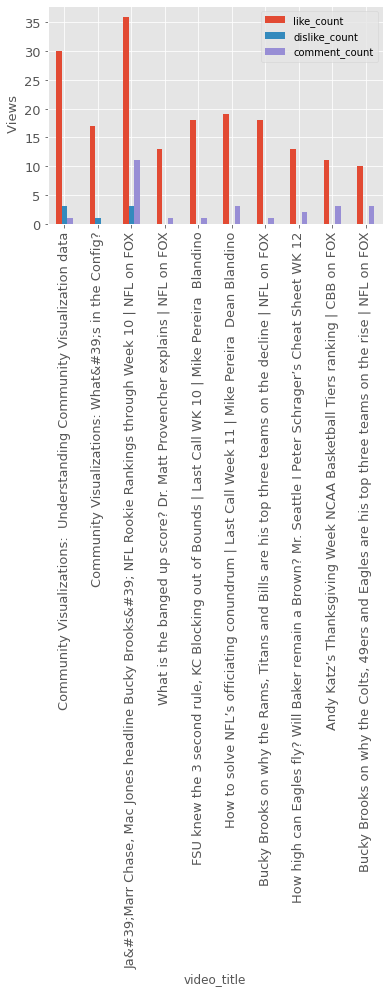

In [31]:
likes_avg = bottom10['like_count']
axis = bottom10.plot.bar(x='video_title', y=['like_count', 'dislike_count', 'comment_count'], fontsize=fontsize)
plt.style.use('ggplot')
axis.set_ylabel(" Views", fontsize=fontsize)

We can see from our results that 9 of the 10 least liked videos actually contain comments. This is interesting when you compare it to the fact that 9 of the 10 most liked videos didn't contain comments. Some of our less viewed videos contain no dislikes at all, which is also interesting. 

### Get Average, Max, Mean, Median for Each of Our Video's Statistics across different channels

Recall our **earlier function** which we could use to take a column from our videos dataFrame and create another dataFrame containing the min, max, mean, median of values for that column in each of our five channels

**Function we create to display multiple data frames**

In [32]:
def display_multiple_frames(*args,headers=cycle([''])):
    html_string=''
    for df,header in zip(args, chain(headers,cycle(['</br>'])) ):
        html_string+='<th style="text-align:center"><td style="vertical-align:top">'
        html_string+=f'<h2>{header}</h2>'
        html_string+=df.to_html().replace('table','table style="display:inline"')
        html_string+='</td></th>'
    display_html(html_string,raw=True)

#### Create and display dataframes for statistics on views likes and dislikes

In [33]:
df_view_stats = compute_category_stats("videos","view_count")
df_like_stats = compute_category_stats("videos","like_count")
df_dislike_stats = compute_category_stats("videos","dislike_count")
display_multiple_frames(df_view_stats, df_like_stats, df_dislike_stats, headers=['Views','Likes', 'Dislikes'])

,Channels,Min,Max,Mean,Median
0,BT Sport,6539,1413556,191743.66,109043.0
1,Fox Sports,75,1499460,180790.54,104993.5
2,Google Analytics,1606,131139,16712.52,7319.5
3,Marvel HQ,4864,22351852,914557.88,48750.5
4,Netflix Futures,2919,6952721,523711.82,111251.5
,Channels,Min,Max,Mean,Median
0,BT Sport,165,14661,3199.50,2144.5
1,Fox Sports,10,20284,2143.58,981.5
2,Google Analytics,17,1207,135.44,74.0
3,Marvel HQ,96,85916,3695.04,597.0


Text(0.5, 1.0, 'Dislikes')

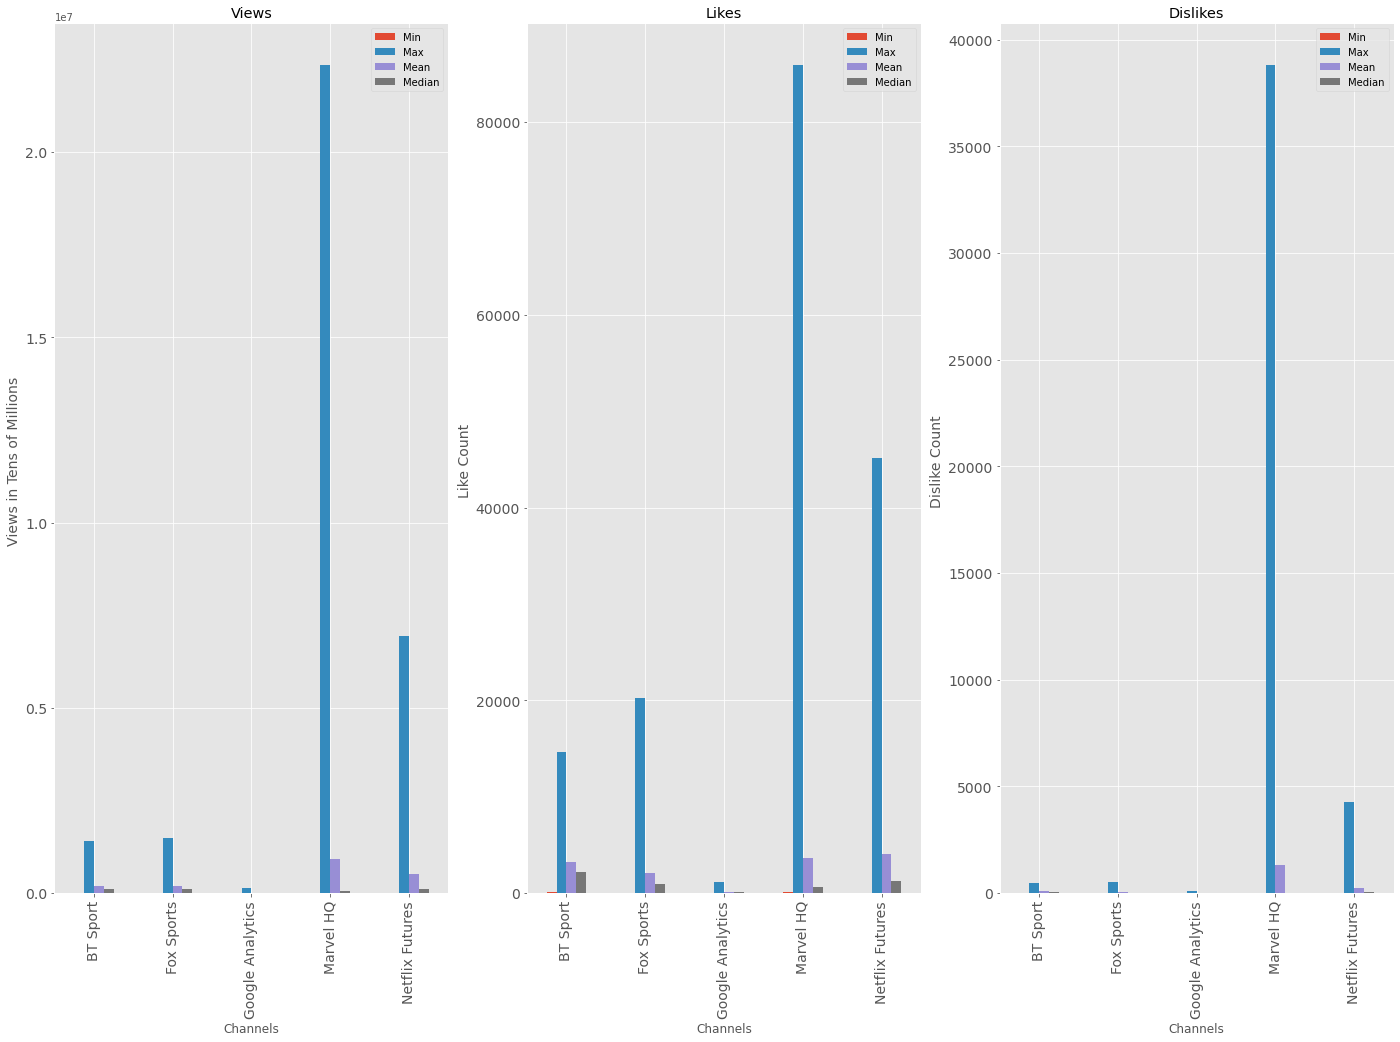

In [34]:
fig, axis = plt.subplots(1,3, figsize=(44,32))
axis1 = df_view_stats.plot.bar(x= 'Channels', y=['Min', 'Max', 'Mean', 'Median'], figsize=(24,16), fontsize = 14, ax=axis[0])
plt.style.use('ggplot')
axis1.set_title("Views")
axis1.set_ylabel("Views in Tens of Millions ", fontsize=14)
ax2 = df_like_stats.plot.bar(x= 'Channels', y=['Min', 'Max', 'Mean', 'Median'], figsize=(24,16), fontsize = 14, ax=axis[1])
plt.style.use('ggplot')
ax2.set_title("Likes")
ax2.set_ylabel("Like Count ", fontsize=14)
ax3 = df_dislike_stats.plot.bar(x= 'Channels', y=['Min', 'Max', 'Mean', 'Median'], figsize=(24,16), fontsize = 14, ax=axis[2])
plt.style.use('ggplot')
ax3.set_ylabel("Dislike Count ", fontsize=14)
ax3.set_title("Dislikes")

We see from our graphs that the channel with the videos that have the highest average and maximum views,likes and dislikes is quite clearly Marvel HQ. Google Analytics has the lowest max and mean video views but it is actually Fox Sports which contains the video with the least amount of views(75). BT Sport contains the highest minimums for views, likes and dislikes, suggesting their all of their videos capture attention. 

## Playlists Analysis

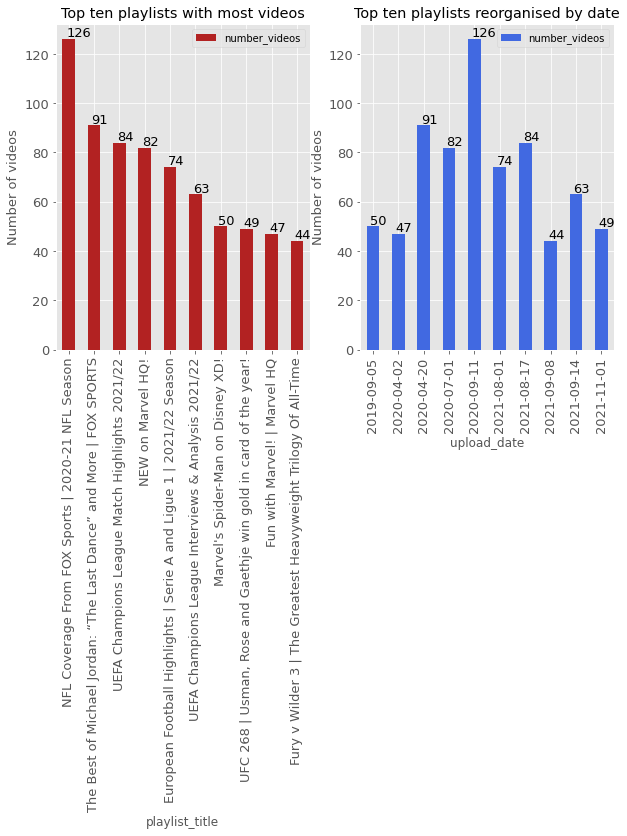

In [83]:
fig, axis = plt.subplots(1,2, figsize=(30,20))
result_df1 = df_categories["playlists"].sort_values(by = 'number_videos', ascending = False)
top10p = result_df1.head(10)
top10p2 = top10p.sort_values(by = 'upload_date', ascending = True)
ax1 = top10p.plot.bar(x='playlist_title', y='number_videos', figsize= (10,6), fontsize=fontsize, ax=axis[0], color = "firebrick")
ax1.set_ylabel("Number of videos", fontsize=13)
ax1.set_title('Top ten playlists with most videos')
for p in ax1.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax1.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)
    

axis2 = top10p2.plot.bar(x='upload_date', y='number_videos', figsize= (10,6), fontsize=13, ax=axis[1], color = "royalblue")
axis2.set_ylabel("Number of videos", fontsize=13)
axis2.set_title('Top ten playlists with most videos')
axis2.set_title("Top ten playlists reorganised by date")
for p in axis2.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    axis2.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)

We see that four of our five channels contain playlists in our top 10 with the most videos. Google Analytics is the only channel that does not have a playlist in the top 10. Fox Sports suprisingly contains the playlist with the most videos and that playlist is the only one that has over 100 videos. BT Sports contains many playlists with a lot of videos. 

Text(0.5, 1.0, 'Bottom ten playlists reorganised by date')

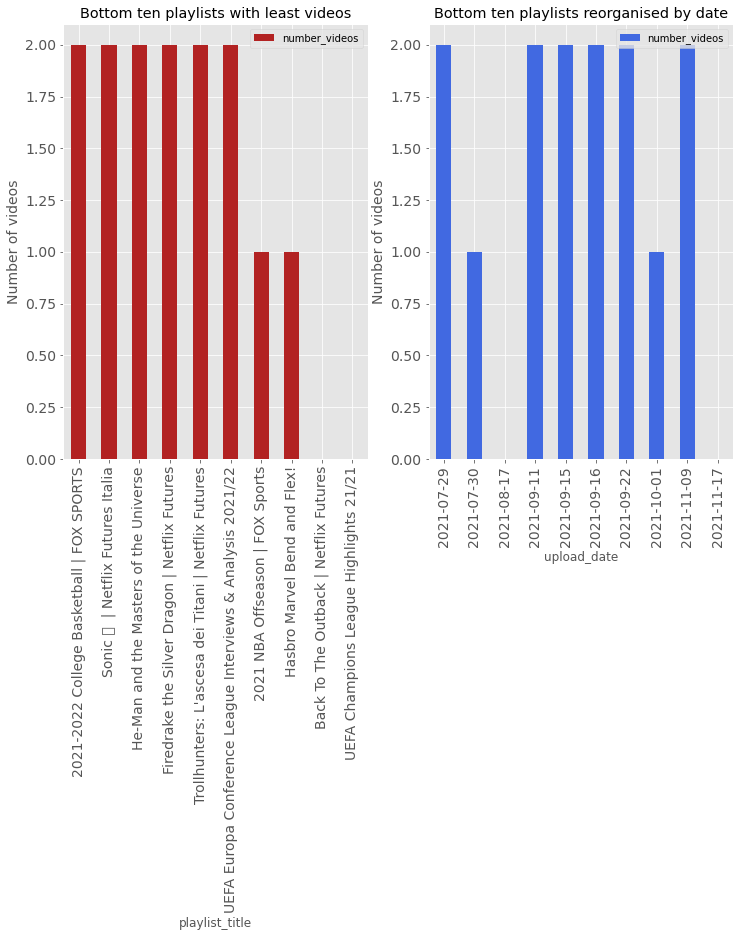

In [84]:

fig, axis = plt.subplots(1,2, figsize=(30,20))
result_df1 = df_categories["playlists"].sort_values(by = 'number_videos', ascending = False)
bottom10p = result_df1.tail(10)
bottom10p2 = bottom10p.sort_values(by = 'upload_date', ascending = True)
ax1 = bottom10p.plot.bar(x='playlist_title', y='number_videos', figsize= (12,8), fontsize=14, ax=axis[0], color = "firebrick")
ax1.set_ylabel("Number of videos", fontsize=14)
ax1.set_title('Bottom ten playlists with least videos')
    

axis2 = bottom10p2.plot.bar(x='upload_date', y='number_videos', figsize= (12,8), fontsize=14, ax=axis[1], color = "royalblue")
axis2.set_ylabel("Number of videos", fontsize=14)
axis2.set_title('Bottom ten playlists with most videos')
axis2.set_title("Bottom ten playlists reorganised by date")

We see from our graphs above that some playlists have zero videos and this is not neccesarily correlated by the date the playlists were created

In [100]:
df_playlist_stats = compute_category_stats("playlists","number_videos")
df_playlist_stats

,playlists,Min,Max,Mean,Median
0,BT Sport,0,84,28.15,22.5
1,Fox Sports,1,126,24.95,16.0
2,Google Analytics,4,32,13.00,12.0
3,Marvel HQ,1,82,22.35,16.0
4,Netflix Futures,0,18,7.55,5.5


Text(0, 0.5, 'Video Count')

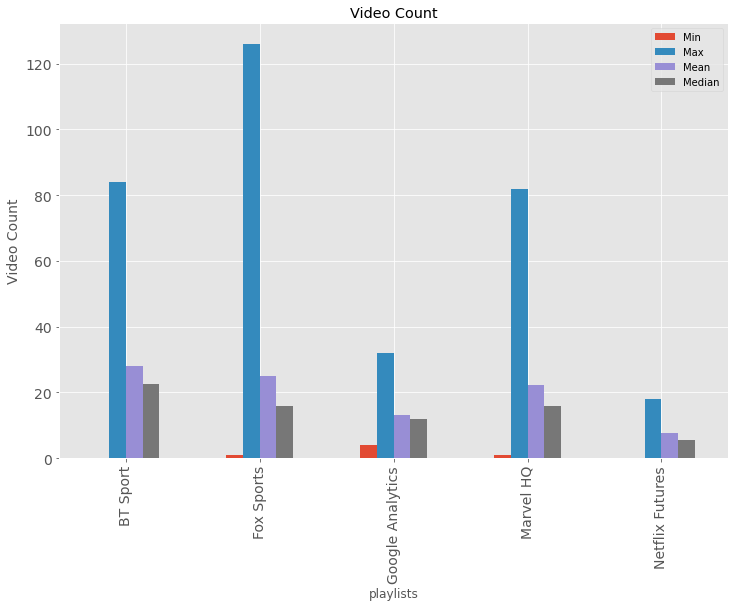

In [124]:
axis1 = df_playlist_stats.plot.bar(x= 'playlists', y=['Min', 'Max', 'Mean', 'Median'], figsize=(12,8), fontsize = 14)
plt.style.use('ggplot')
axis1.set_title("Video Count")
axis1.set_ylabel("Video Count", fontsize=14)

We see that Fox Sports playlists have the most videos on average

## Channels analysis

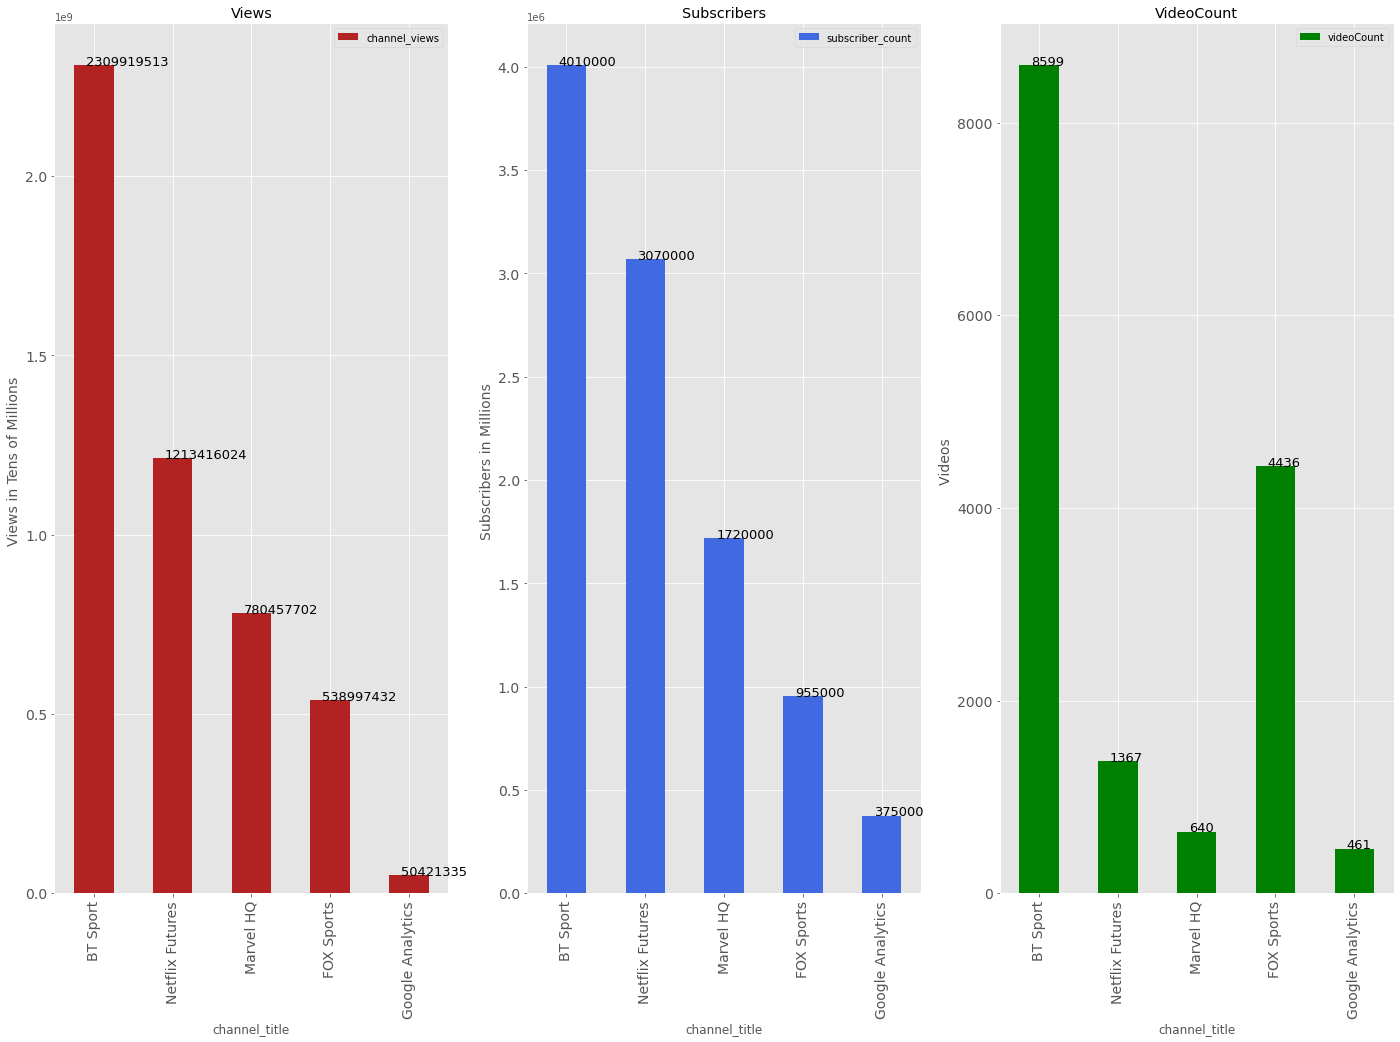

In [123]:
fig, axis = plt.subplots(1,3, figsize=(44,32))
# channel launch, channel views, sub count, video count
resulting_df = df_categories["channels"].sort_values(by = 'channel_views', ascending = False)
axis1 = resulting_df.plot.bar(x='channel_title', y='channel_views',figsize=(24,16), fontsize = 14, ax=axis[0],color = "firebrick")
plt.style.use('ggplot')
axis1.set_title("Views")
axis1.set_ylabel("Views in Tens of Millions ", fontsize=14)

for p in axis1.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    axis1.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)
    
axis2 = resulting_df.plot.bar(x='channel_title', y='subscriber_count',figsize=(24,16), fontsize = 14, ax=axis[1], color = "royalblue")
plt.style.use('ggplot')
axis2.set_title("Subscribers")
axis2.set_ylabel("Subscribers in Millions ", fontsize=14)

for p in axis2.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    axis2.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)
    
axis3 = resulting_df.plot.bar(x='channel_title', y='videoCount',figsize=(24,16), fontsize = 14, ax=axis[2], color = "green")
plt.style.use('ggplot')
axis3.set_title("VideoCount")
axis3.set_ylabel("Videos ", fontsize=14)

for p in axis3.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    axis3.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)

We can see that BT Sports has the most views, subscribers and videos

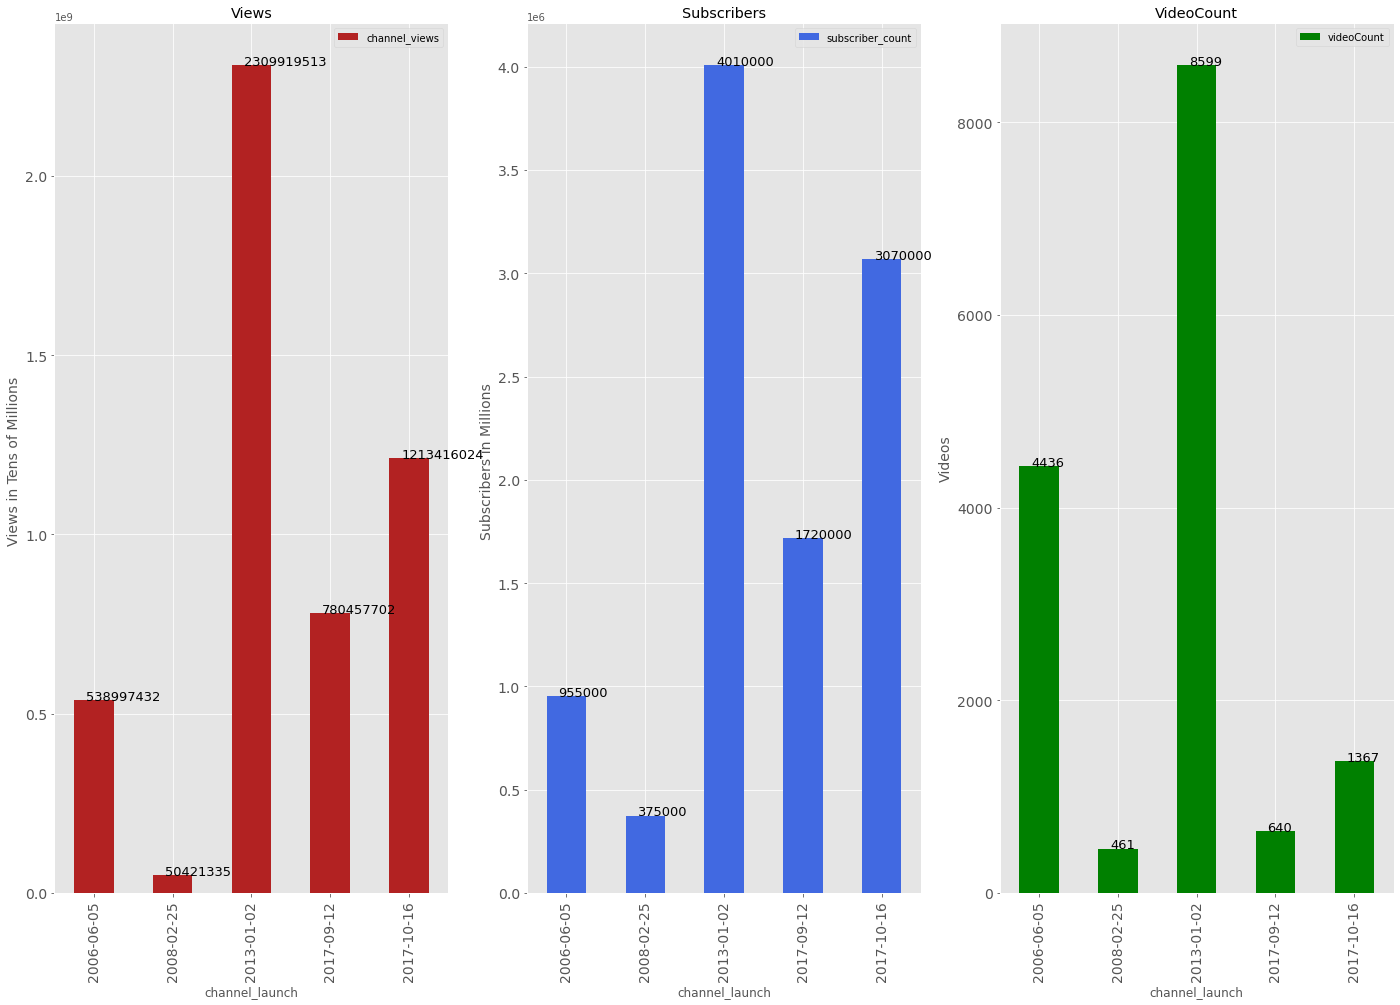

In [122]:
fig, axis = plt.subplots(1,3, figsize=(44,32))
# channel launch, channel views, sub count, video count
resulting_df = df_categories["channels"].sort_values('channel_launch', ascending = True)
axis1 = resulting_df.plot.bar(x='channel_launch', y='channel_views',figsize=(24,16), fontsize = 14, ax=axis[0],color = "firebrick")
plt.style.use('ggplot')
axis1.set_title("Views")
axis1.set_ylabel("Views in Tens of Millions ", fontsize=14)

for p in axis1.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    axis1.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)
    
axis2 = resulting_df.plot.bar(x='channel_launch', y='subscriber_count',figsize=(24,16), fontsize = 14, ax=axis[1], color = "royalblue")
plt.style.use('ggplot')
axis2.set_title("Subscribers")
axis2.set_ylabel("Subscribers in Millions ", fontsize=14)

for p in axis2.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    axis2.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)
    
axis3 = resulting_df.plot.bar(x='channel_launch', y='videoCount',figsize=(24,16), fontsize = 14, ax=axis[2], color = "green")
plt.style.use('ggplot')
axis3.set_title("VideoCount")
axis3.set_ylabel("Videos", fontsize=14)

for p in axis3.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    axis3.annotate(val, ((b.x0 + b.x1)/2 + -0.1, b.y1 + 1.0), fontsize=fontsize)

We see that launch date doesn't correlate to views, subs or video amount 

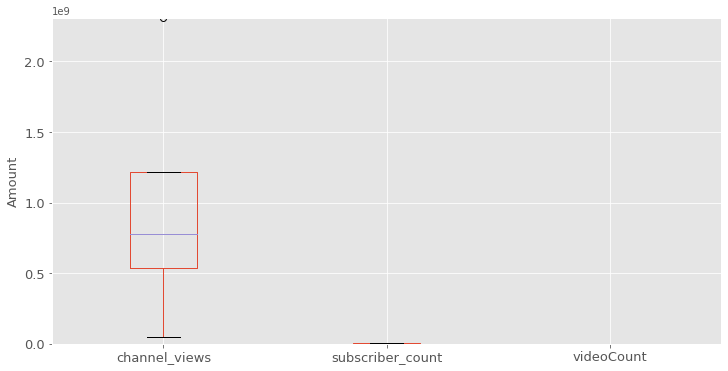

In [120]:
target_columns = ["channel_views", "subscriber_count", "videoCount"]
df_all2 = resulting_df[target_columns]
#ax = scatter_matrix(df_all2, figsize=(12,10), alpha=0.3)
ax = df_all2.boxplot(figsize=(12,6), fontsize=fontsize)
ax.set_ylim(0, df_all2["channel_views"].max()+1)
ax.set_ylabel("Amount", fontsize=fontsize);

## Conclusions
In this assignment we looked at the analysis of channel data (videos, playlists) for five different channels, focusing particularly on views, likes, dislikes, dates, video counts, comments. As we might expect, Marvel HQ was the channel with the most viewed, liked and disliked video (and the most for the averages) however BT Sport has the most subscibers, overall channel views and videos. Fox Sport had the most playlists and BT had a lot of playlists with lots of videos which suggests that sport channels contain lots of playlists. 

One particular challenge of using the free Youtube Data API v3 is that we could not retrieve playlist views and we could only analyse a certain amount of channels as data would become too hard to analyse if we chose too many channels. Another problem is that Marvel HQ often had vast differnces in maximums and minimums. A considerable level of data preprocessing was also required to merge the raw data into a single dataset for each city.

A number of interesting avenues could be considered for further analysis of this data:

The analysis could have been extended to more channels that ranged more in video count and subscribers to further investigate youtube channel differences. We could also have specified video categories and analyse a specific subsey of youtube channels (like Sports channels).

If further channel data was available, we could see the reason channels have more views than others and why comments were disabled on specific channels (e.g. kid friendly channels).
Again if we had further data on playlists/videos, we could analyse deeper into why the videos of a particular catgeory had more views than others and which playlists contained the most views and what category they fell into.